In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: Tesla T4


# **TRANSFORMS**

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

dataset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=train_transform
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

test_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=test_transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

100%|██████████| 169M/169M [00:18<00:00, 9.18MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


# Why normalization must match ImageNet?

*   ResNet50 was pretrained on ImageNet.
*   Convolution filters expect inputs centered using ImageNet statistics.
*   Mismatch shifts activation distributions and reduces transfer efficiency.

# Why augmentation improves generalization?

*   CIFAR-100 has limited resolution and class imbalance.
*   Augmentation increases data diversity.
*   Encourages invariance to spatial distortions.
*   Reduces overfitting during fine-grained learning.

# **Feature** **Extraction**

In [ ]:
import torch.nn as nn
import torchvision.models as models

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
num_classes = 100

model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

# He Initialization
for m in model.modules():
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


# **Why He Initialization?**

*   ReLU discards negative activations.
*   He initialization preserves forward variance.
*   Prevents vanishing/exploding gradients.
*   Especially important when training only the new classifier head.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    model.fc.parameters(),
    lr=1e-3,
    weight_decay=1e-4  # L2 regularization
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)

In [ ]:
import copy

best_val_loss = float('inf')
patience = 5
counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

In [ ]:
num_epochs = 20

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / len(train_loader.dataset)

    model.eval()
    val_loss, val_correct = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / len(val_loader.dataset)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

model.load_state_dict(best_model_wts)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


Epoch 1: Train Acc=0.3308, Val Acc=0.4772
Epoch 2: Train Acc=0.4314, Val Acc=0.5002
Epoch 3: Train Acc=0.4581, Val Acc=0.5129
Epoch 4: Train Acc=0.4689, Val Acc=0.5326


KeyboardInterrupt: 

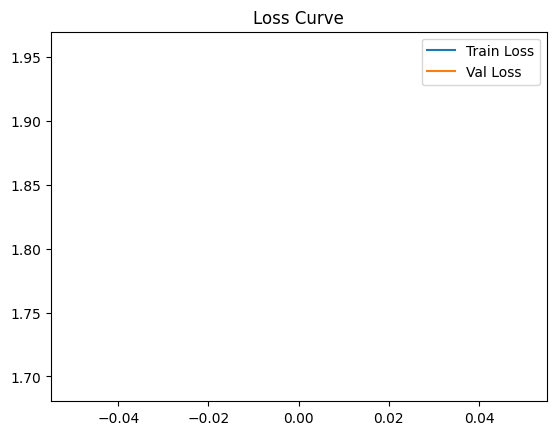

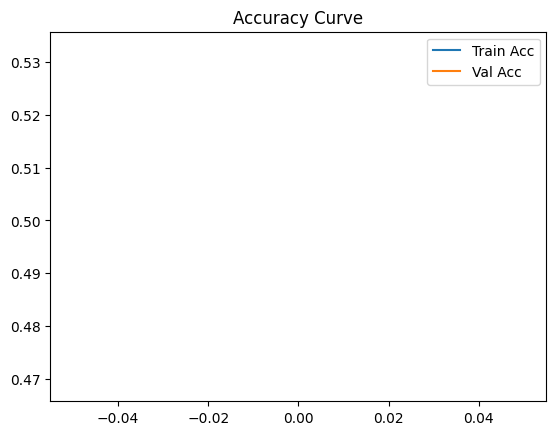

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")
plt.show()

# Why early stopping is critical here?

*   CIFAR-100 is fine-grained → easier to overfit.
*   Transfer learning converges rapidly.
*   Prevents memorization of small-scale patterns.

# Why weight decay is important?

*   CIFAR-100 has 100 classes → high classifier complexity.
*   L2 penalizes large weights.
*   Encourages smoother decision boundaries.

In [ ]:
for name, param in model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5,
    weight_decay=1e-4
)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm)

print(classification_report(all_labels, all_preds))

[[88  0  0 ...  0  0  0]
 [ 0 66  0 ...  0  0  0]
 [ 1  0 47 ...  0  3  0]
 ...
 [ 0  0  0 ... 53  0  0]
 [ 0  0  2 ...  0 35  0]
 [ 0  0  0 ...  0  0 74]]
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       100
           1       0.84      0.66      0.74       100
           2       0.59      0.47      0.53       100
           3       0.67      0.34      0.45       100
           4       0.53      0.20      0.29       100
           5       0.39      0.79      0.52       100
           6       0.67      0.29      0.41       100
           7       0.45      0.64      0.53       100
           8       0.62      0.81      0.70       100
           9       0.91      0.72      0.80       100
          10       0.44      0.52      0.48       100
          11       0.56      0.27      0.36       100
          12       0.69      0.50      0.58       100
          13       0.55      0.58      0.56       100
          14       0.36      0.72

### Load and Display an Image

First, let's load an image using OpenCV. You can replace `image_path` with the path to your desired image.

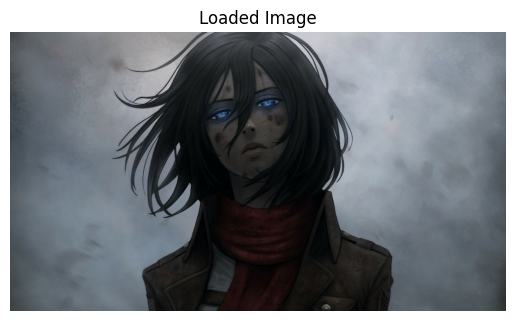

In [7]:
import os
import cv2
import matplotlib.pyplot as plt

# NOTE: Replace 'path/to/your/image.jpg' with the actual path to your image file from your workspace.
# For example: image_path = '/content/my_image.jpg'
image_path = '/content/sample_image.jpg' # <--- REPLACE THIS WITH YOUR IMAGE PATH

img = None
if image_path and os.path.exists(image_path):
    # Load the image
    img = cv2.imread(image_path)

    if img is not None:
        # OpenCV loads images in BGR format, matplotlib expects RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image
        plt.imshow(img_rgb)
        plt.title('Loaded Image')
        plt.axis('off')
        plt.show()
    else:
        print(f"Error: Could not load image from {image_path}. Please check the file path and integrity.")
else:
    print(f"No image path provided or file does not exist at {image_path}. Please set a valid `image_path`.")


### Predict the Class of the Image

Now, let's preprocess the loaded image and use our trained model to predict its class.

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])

# Dataset
trainset = torchvision.datasets.CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=64,
    shuffle=True
)

# Model
model = torchvision.models.resnet18(num_classes=100)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training (1 epoch demo)
for epoch in range(1):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print("Epoch Loss:", running_loss)

# Save model
torch.save(model.state_dict(), "cifar100_model.pth")
print("Model Saved!")

100%|██████████| 169M/169M [00:05<00:00, 30.4MB/s]


Epoch Loss: 2753.1837210655212
Model Saved!


In [16]:
model.load_state_dict(torch.load("cifar100_model.pth", map_location=device))

<All keys matched successfully>

In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# 1️⃣ Transforms
# ---------------------------
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])

# ---------------------------
# 2️⃣ Dataset
# ---------------------------
trainset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# ---------------------------
# 3️⃣ Model
# ---------------------------
model = torchvision.models.resnet18(num_classes=100)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------------------
# 4️⃣ Training
# ---------------------------
epochs = 5  # Increase to 15-20 for better accuracy

train_losses = []
test_accuracies = []

for epoch in range(epochs):

    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss)

    # ---------------------------
    # 5️⃣ Evaluation
    # ---------------------------
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss:.4f} Test Accuracy: {accuracy:.2f}%")

# ---------------------------
# 6️⃣ Save Model
# ---------------------------
torch.save(model.state_dict(), "cifar100_model.pth")
print("Model Saved Successfully!")

Epoch [1/5] Loss: 1366.4495 Test Accuracy: 22.81%
Epoch [2/5] Loss: 1081.5538 Test Accuracy: 31.55%
Epoch [3/5] Loss: 933.0294 Test Accuracy: 37.64%
Epoch [4/5] Loss: 835.5033 Test Accuracy: 40.52%
Epoch [5/5] Loss: 750.7817 Test Accuracy: 44.04%
Model Saved Successfully!


Predicted: skyscraper
Confidence: 0.9196772575378418


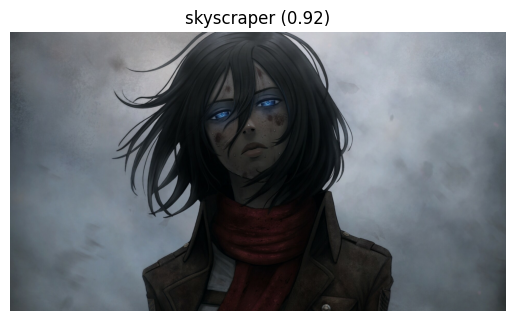

In [19]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Load model
model = torchvision.models.resnet18(num_classes=100)
model.load_state_dict(torch.load("cifar100_model.pth", map_location=device))
model.to(device)
model.eval()

# Load class names
cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=False)
class_names = cifar100.classes

# Load custom image
image_path = "/content/sample_image.jpg"   # change this
img = cv2.imread(image_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pil_img = Image.fromarray(img_rgb)

# Transform
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])

input_img = transform(pil_img).unsqueeze(0).to(device)

# Predict
with torch.no_grad():
    outputs = model(input_img)
    probabilities = torch.softmax(outputs, dim=1)
    prob, pred = torch.max(probabilities, 1)

predicted_class = class_names[pred.item()]

print("Predicted:", predicted_class)
print("Confidence:", prob.item())

# Show image
plt.imshow(img_rgb)
plt.title(f"{predicted_class} ({prob.item():.2f})")
plt.axis("off")
plt.show()